# Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.formula.api import ols

pd.set_option('display.max_columns', 500)

In [2]:
df = pd.read_csv('data/cleaned_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10476 entries, 0 to 10475
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      10476 non-null  int64  
 1   App             10476 non-null  object 
 2   Category        10476 non-null  object 
 3   Rating          10476 non-null  float64
 4   Reviews         10476 non-null  float64
 5   Size            10476 non-null  float64
 6   Installs        10476 non-null  int64  
 7   Content Rating  10476 non-null  object 
 8   Genres          10476 non-null  object 
 9   Month           10476 non-null  int64  
 10  is_free         10476 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 900.4+ KB


In [4]:
df.drop(['Unnamed: 0', 'App'], axis=1, inplace=True)

In [5]:
# df['Rating'] = df['Rating'].round()

In [6]:
# df['Rating'] = df['Rating'].astype('object')

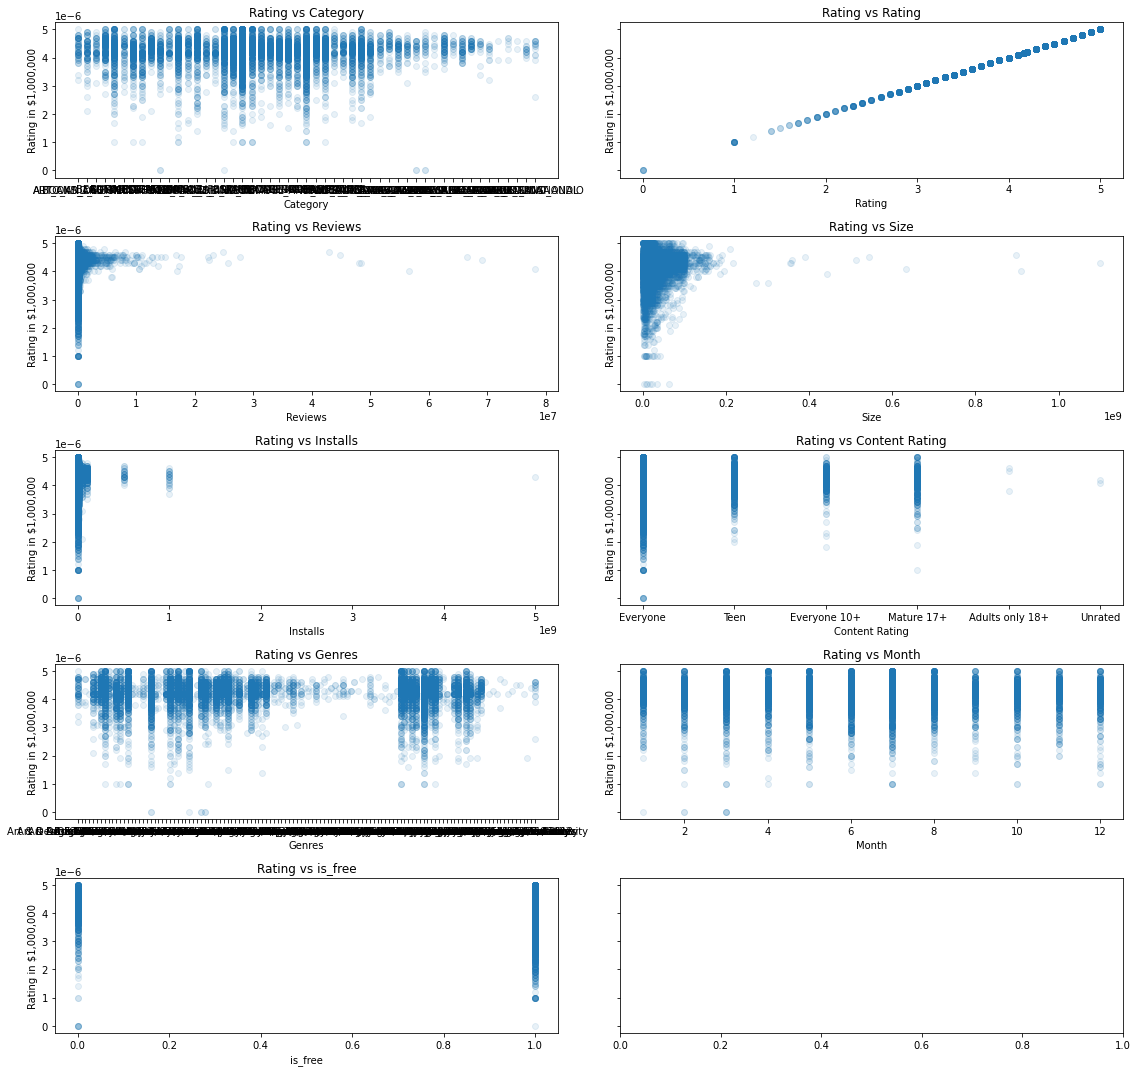

In [7]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16,15), sharey=True)

for ax, column in zip(axes.flatten(), df.columns):
    ax.scatter(df[column], df['Rating'] / 1_000_000, label=column, alpha=.1)
    ax.set_title(f'Rating vs {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Rating in $1,000,000')

fig.tight_layout()

Clearly, the data needs a lot of preprocessing to improve the results. Here you can see the relationship between 'Rating' and the independent variables. We can see what variables are continuous(Reviews, Size, and Installs) and categorical(Category, Content Rating, and Month).

In [ ]:
# df['Month'] = df['Month'].astype('object')

In [ ]:
cats = df.select_dtypes(include='object')

In [ ]:
cats

In [ ]:
cats_dummies = pd.get_dummies(cats, columns=['Category', 'Rating', 'Content Rating', 'Genres'], drop_first=True)

In [ ]:
model_df = pd.concat((df, cats_dummies), axis=1)
model_df.drop(columns=['Category', 'Rating''Content Rating', 'Genres'], axis = 1, inplace=True)
model_df

In [ ]:
model_df.info()

In [ ]:
model_df.columns = model_df.columns.str.replace(' ', '_').str.replace('+','')

# Linear Regression Model

In [ ]:
y = model_df['Rating']
X = model_df.drop(['Rating'], axis =1)

In [ ]:
X.head()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [ ]:
for col in X.columns:
    # Subtract the minimum and divide by the range forcing a scale of 0 to 1 for each feature
    X[col] = (X[col] - min(X[col]))/ (max(X[col]) - min(X[col])) 

X.head()

In [ ]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

In [ ]:
linreg.fit(X_train, y_train)

In [ ]:
accuracy = linreg.score(X_test, y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

## KNeighbors Regression

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=180)
knn.fit(X_train,y_train)

In [ ]:
accuracy = knn.score(X_test, y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

In [ ]:
n_neighbors = np.arange(20, 300, 10)
scores = []
for n in n_neighbors:
    knn.set_params(n_neighbors=n)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure(figsize=(7, 5))
plt.title("Effect of Estimators")
plt.xlabel("Number of Neighbors K")
plt.ylabel("Score")
plt.plot(n_neighbors, scores)

In [ ]:
print("max accuracy is: ", max(scores))
print("K value to achieve this result: ", n_neighbors[scores.index(max(scores))])

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
decision_tree = DecisionTreeRegressor()

In [ ]:
decision_tree.fit(X_train,y_train)

In [ ]:
accuracy = decision_tree.score(X_test, y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
estimators = np.arange(10, 150, 10)
scores = []
for n in estimators:
    rf.set_params(n_estimators=n)
    rf.fit(X_train, y_train)
    scores.append(rf.score(X_test, y_test))
plt.figure(figsize=(7, 5))
plt.title("Effect of Estimators")
plt.xlabel("no. estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [ ]:
print("max accuracy is: ", max(scores))
print("Estimators to achieve this result: ", estimators[scores.index(max(scores))])

# Outliers

In [ ]:
from numpy import mean
from numpy import std

In [ ]:
sns.boxplot(x=model_df['Reviews'])

In [ ]:
def outliers(col, df):
    mean = df[col].mean()
    std = df[col].std()
    cut_off = std * 3
    lower = mean - cut_off
    upper = mean + cut_off
    outliers = [x for x in df[col] if x < lower or x > upper]
    return sorted(outliers)

In [ ]:
outliers('Reviews', model_df)

In [ ]:
model_out = model_df[(model_df['Reviews'] <= 6074334) & (model_df['Reviews'] >= 100)]
model_out.reset_index(drop=True)

In [ ]:
sns.boxplot(x=model_df['Installs'])

In [ ]:
outliers('Installs', model_out)

In [ ]:
model_out = model_out[(model_out['Installs'] < 50000000) & (model_out['Installs'] >= 1000)]
model_out.reset_index(drop=True)

In [ ]:
sns.boxplot(x=model_out['Installs'])

In [ ]:
sns.boxplot(x=model_out['Size'])

In [ ]:
outliers('Size', model_out)

In [ ]:
model_out = model_out[(model_out['Size'] < 123000000)]
model_out.reset_index(drop=True)

In [ ]:
sns.boxplot(x=model_out['Rating'])

The median looks to be around 4.3. Anything beyond 3.3 and 5 are outliers. We will use these as our markers.

In [ ]:
model_out = model_out[(model_out['Rating'] > 3.3)]
model_out.reset_index(drop=True)

In [ ]:
model_out.describe()

# Model - Outliers Fixed

In [ ]:
y = model_out['Rating']
X = model_out.drop(['Rating'], axis =1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [ ]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
accuracy = linreg.score(X_test, y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

## KNeighbors Regression

In [ ]:
n_neighbors = np.arange(20, 300, 10)
scores = []
for n in n_neighbors:
    knn.set_params(n_neighbors=n)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure(figsize=(7, 5))
plt.title("Effect of Estimators")
plt.xlabel("Number of Neighbors K")
plt.ylabel("Score")
plt.plot(n_neighbors, scores)

In [ ]:
print("max accuracy is: ", max(scores))
print("K value to achieve this result: ", n_neighbors[scores.index(max(scores))])

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=70)
knn.fit(X_train,y_train)
accuracy = knn.score(X_test, y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train,y_train)

In [ ]:
accuracy = decision_tree.score(X_test, y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
estimators = np.arange(10, 150, 10)
scores = []
for n in estimators:
    rf.set_params(n_estimators=n)
    rf.fit(X_train, y_train)
    scores.append(rf.score(X_test, y_test))
plt.figure(figsize=(7, 5))
plt.title("Effect of Estimators")
plt.xlabel("no. estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [ ]:
print("max accuracy is: ", max(scores))
print("Estimators to achieve this result: ", estimators[scores.index(max(scores))])

# Transform

In [ ]:
df_log = model_out.copy()

In [ ]:
df_log[['Rating', 'Reviews', 'Size', 'Installs']].hist(figsize=(15,12));

All the continuous variable are very skewed. Major outliers with Reviews and Installs. 

In [ ]:
df_log['log_Rating'] = np.log(df_log['Rating'])
df_log[['Rating', 'log_Rating']].hist(figsize=(12,5));

df_log['log_Reviews'] = np.log(df_log['Reviews'])
df_log[['Reviews', 'log_Reviews']].hist(figsize=(12,5));

df_log['log_Size'] = np.log(df_log['Size'])
df_log[['Size', 'log_Size']].hist(figsize=(12,5));

df_log['log_Installs'] = np.log(df_log['Installs'])
df_log[['Installs', 'log_Installs']].hist(figsize=(12,5));

In [ ]:
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

In [ ]:
# df_log_norm = df_log[['log_Rating']]
df_log_norm = df_log[['log_Rating', 'log_Installs', 'log_Size', 'log_Reviews']]

In [ ]:
df_log_norm = df_log_norm.apply(normalize)
df_log_norm.hist(figsize=(10,10));

In [ ]:
df_log['Rating'] = df_log_norm['log_Rating']
df_log['log_Installs'] = df_log_norm['log_Installs']
df_log['log_Size'] = df_log_norm['log_Size']
df_log['log_Reviews'] = df_log_norm['log_Reviews']

In [ ]:
df_log.info()

In [ ]:
df_log = df_log.drop(['Rating', 'Reviews', 'Installs', 'Size'], axis=1)

# Model - Variables Transformed

## Linear Regression

In [ ]:
y = df_log['log_Rating']
X = df_log.drop(['log_Rating'], axis =1)

In [ ]:
X.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [ ]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
accuracy = linreg.score(X_test, y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

## KNeighbors Regression

In [ ]:
n_neighbors = np.arange(20, 300, 10)
scores = []
for n in n_neighbors:
    knn.set_params(n_neighbors=n)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure(figsize=(7, 5))
plt.title("Effect of Estimators")
plt.xlabel("Number of Neighbors K")
plt.ylabel("Score")
plt.plot(n_neighbors, scores)

In [ ]:
print("max accuracy is: ", max(scores))
print("K value to achieve this result: ", n_neighbors[scores.index(max(scores))])

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=40)
knn.fit(X_train,y_train)
accuracy = knn.score(X_test, y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train,y_train)

In [ ]:
accuracy = decision_tree.score(X_test, y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
estimators = np.arange(10, 150, 10)
scores = []
for n in estimators:
    rf.set_params(n_estimators=n)
    rf.fit(X_train, y_train)
    scores.append(rf.score(X_test, y_test))
plt.figure(figsize=(7, 5))
plt.title("Effect of Estimators")
plt.xlabel("no. estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [ ]:
print("max accuracy is: ", max(scores))
print("Estimators to achieve this result: ", estimators[scores.index(max(scores))])